# Visualization

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
flu_data = sc.read_h5ad("../data/inference/influenza_lee_czi_preds.h5ad")

In [ ]:
flu_data.obs.predicted_celltype.value_counts()


########## ORIGINAL CELLTYPE ANNOTATIONS ##########

# classical monocyte                           5296
# CD8-positive, alpha-beta T cell              1452
# natural killer cell                          1449
# effector CD4-positive, alpha-beta T cell      383
# IgG-negative class switched memory B cell     322
# erythrocyte                                   309
# effector CD8-positive, alpha-beta T cell      300
# blood cell                                    216
# non-classical monocyte                        211
# platelet                                      182
# intermediate monocyte                         161
# IgG memory B cell                             133
# CD4-positive helper T cell                     66
# dendritic cell                                 39


############### PREDICTED CELLTYPE ANNOTATIONS ################
# classical monocyte                                       4810 clasical monocyte
# effector memory CD8-positive, alpha-beta T cell          2185 effector memory CD8-positive, alpha-beta T cell
# natural killer cell                                       911 natural killer cell
# monocyte                                                  504
# erythrocyte                                               392 erythrocyte
# central memory CD4-positive, alpha-beta T cell            286 
# naive B cell                                              276
# non-classical monocyte                                    162
# CD4-positive, alpha-beta cytotoxic T cell                 140
# platelet                                                  137
# lymphocyte                                                122
# memory B cell                                              94
# CD8-positive, alpha-beta T cell                            81
# neutrophil                                                 71
# transitional stage B cell                                  66
# myeloid cell                                               42
# naive thymus-derived CD4-positive, alpha-beta T cell       32
# CD14-positive monocyte                                     27
# regulatory T cell                                          26
# gamma-delta T cell                                         26
# plasmablast                                                17
# conventional dendritic cell                                15
# mucosal invariant T cell                                   13
# plasmacytoid dendritic cell, human                         10
# B cell                                                      6
# dendritic cell                                              6
# mature alpha-beta T cell                                    6
# T cell                                                      6
# activated CD8-positive, alpha-beta T cell, human            6
# CD14-positive, CD16-negative classical monocyte             5
# immature neutrophil                                         4
# IgG plasmablast                                             4
# IgA plasmablast                                             3
# blood cell                                                  3
# hematopoietic stem cell                                     3
# effector CD8-positive, alpha-beta T cell                    3
# CD4-positive, alpha-beta memory T cell                      2
# CD4-positive, alpha-beta T cell                             2
# CD14-low, CD16-positive monocyte                            2
# activated CD4-positive, alpha-beta T cell, human            2
# naive thymus-derived CD8-positive, alpha-beta T cell        2
# mature NK T cell                                            2
# CD16-negative, CD56-bright natural killer cell, human       2
# CD4-positive helper T cell                                  1
# T follicular helper cell                                    1
# CD16-positive, CD56-dim natural killer cell, human          1
# megakaryocyte                                               1
# megakaryocyte-erythroid progenitor cell                     1


# remap_dict = {

# }

predicted_celltype
classical monocyte                                       4810
effector memory CD8-positive, alpha-beta T cell          2185
natural killer cell                                       911
monocyte                                                  504
erythrocyte                                               392
central memory CD4-positive, alpha-beta T cell            286
naive B cell                                              276
non-classical monocyte                                    162
CD4-positive, alpha-beta cytotoxic T cell                 140
platelet                                                  137
lymphocyte                                                122
memory B cell                                              94
CD8-positive, alpha-beta T cell                            81
neutrophil                                                 71
transitional stage B cell                                  66
myeloid cell                                       

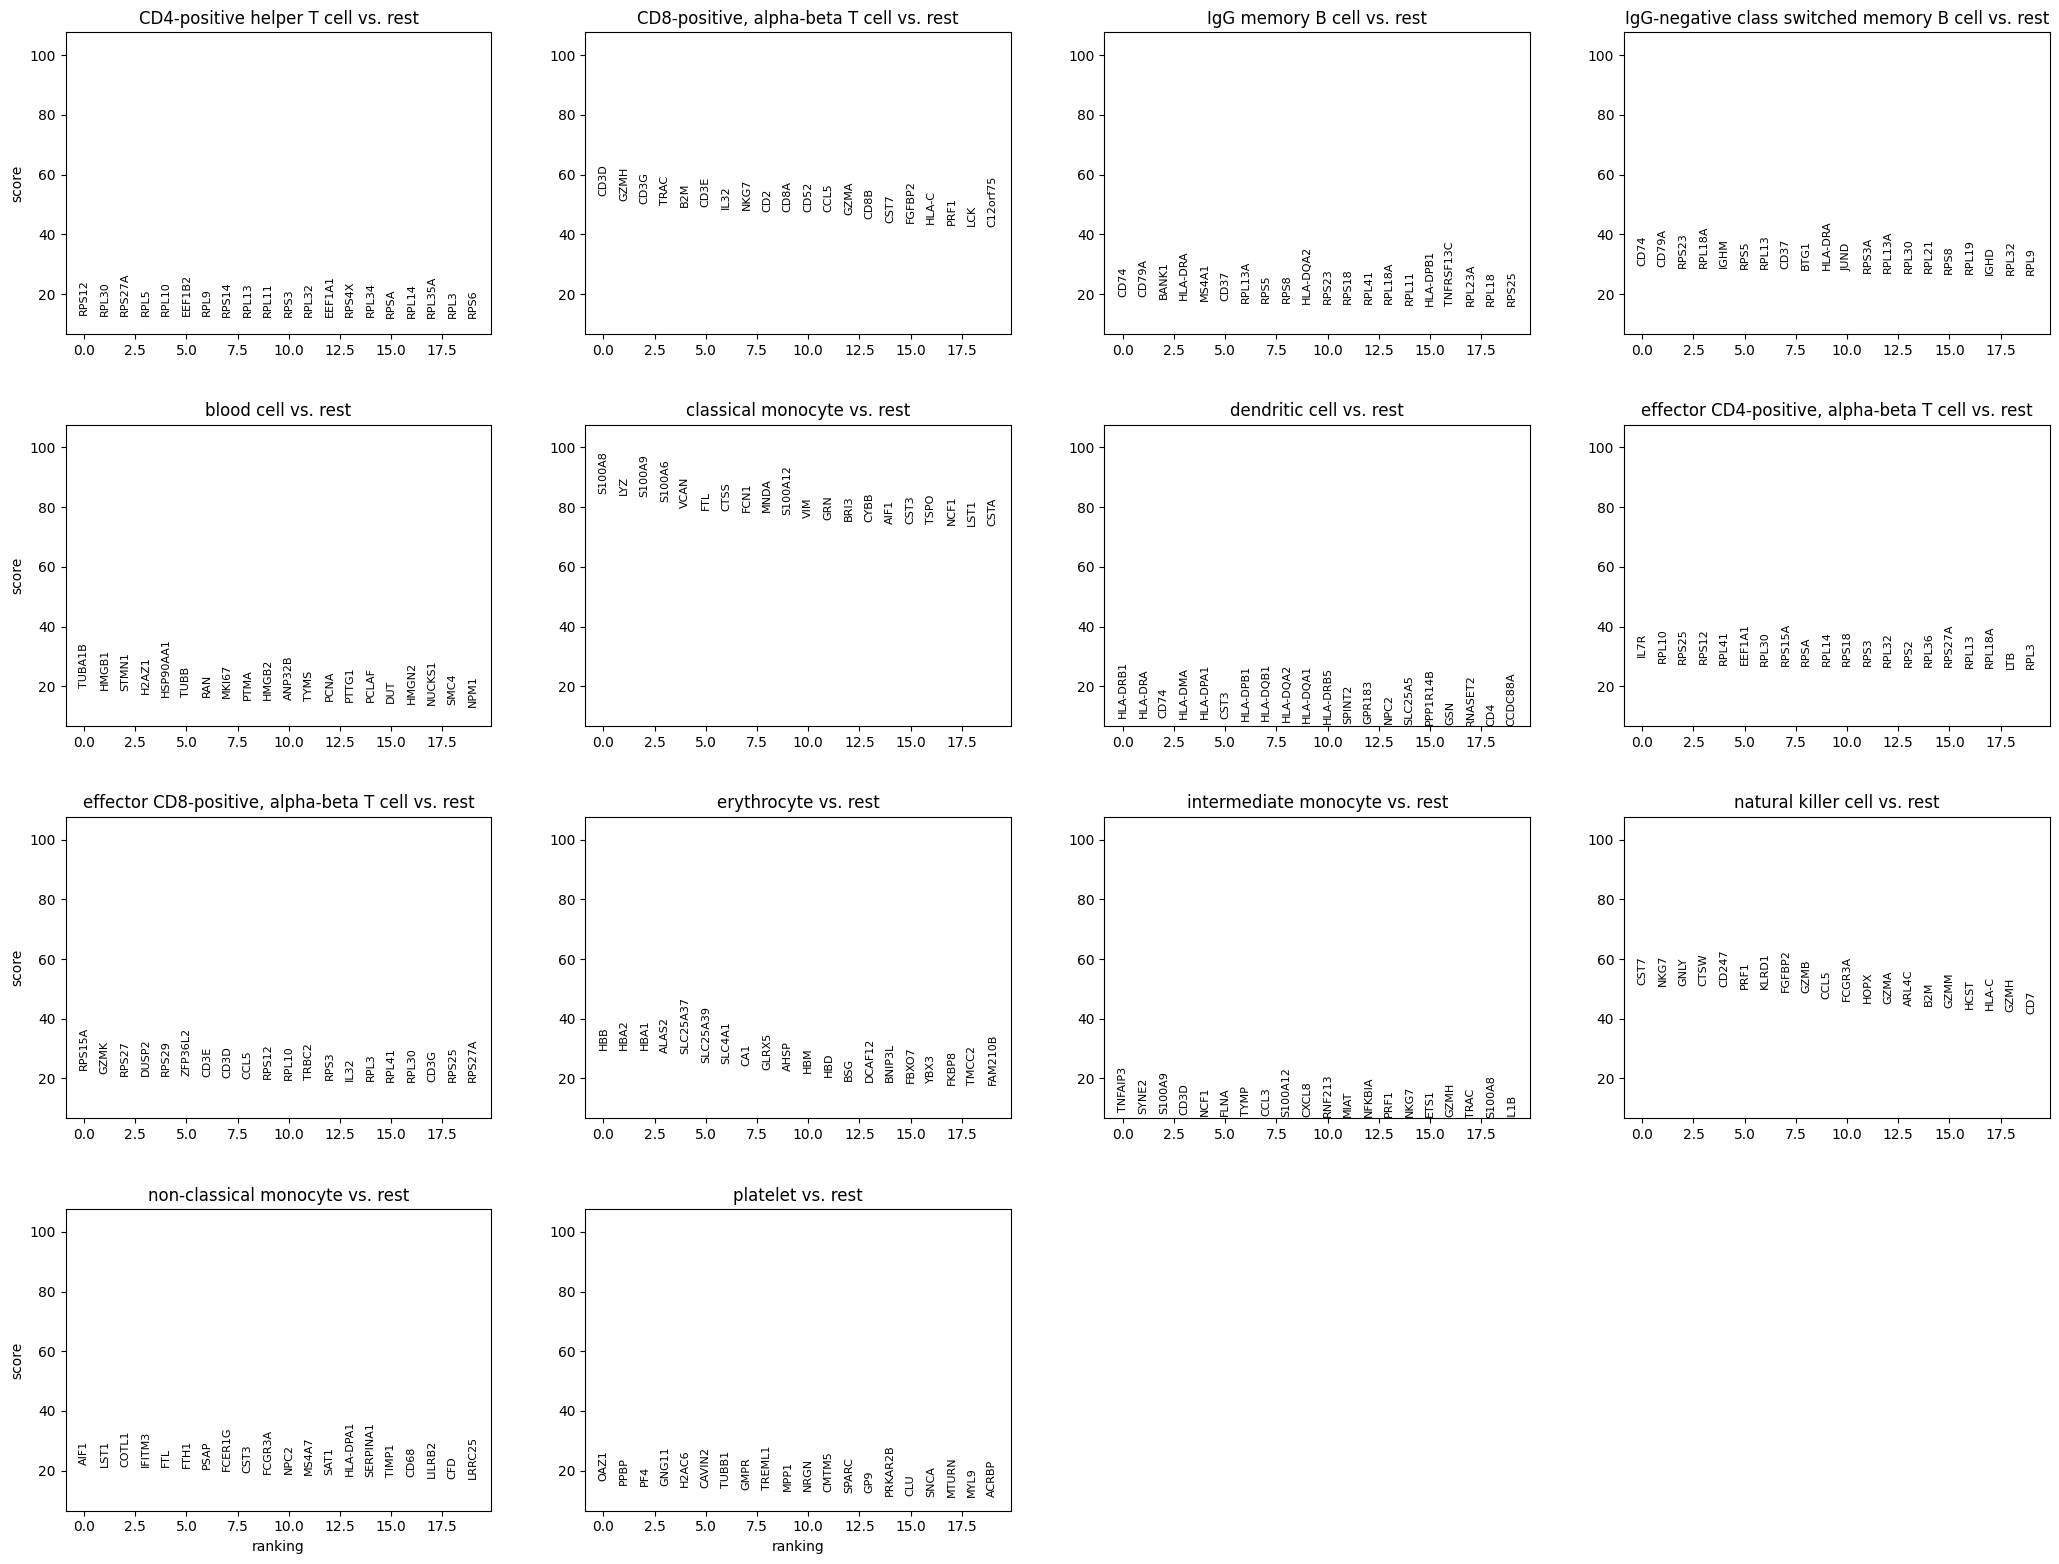

In [22]:
sc.pp.normalize_total(flu_data, target_sum=1e4)
sc.pp.log1p(flu_data)

sc.tl.rank_genes_groups(flu_data, groupby="cell_type", method="wilcoxon")

sc.pl.rank_genes_groups(flu_data)

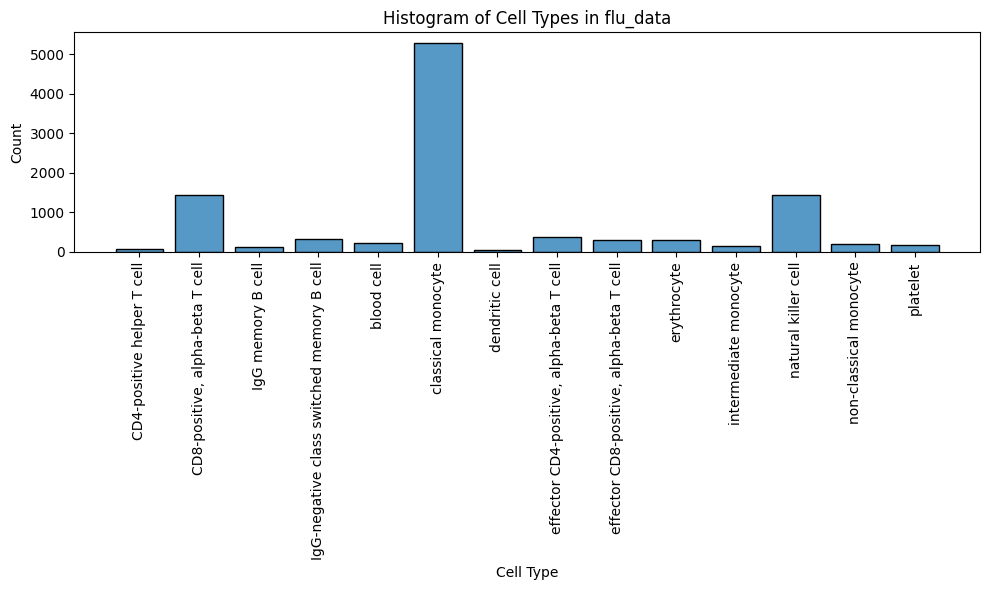

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(flu_data.obs["cell_type"], discrete=True, shrink=0.8)
plt.xticks(rotation=90)
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.title("Histogram of Cell Types in flu_data")
plt.tight_layout()
plt.show()


In [ ]:
czi_reference = sc.read_h5ad("../data/datasets/czi_covid_pbmc_5pct.h5ad")
id2type = dict(enumerate(czi_reference.obs["cell_type"].astype("category").cat.categories))
# czi_reference.obs.cell_type

In [ ]:
adata_read = sc.read_h5ad("../data/inference/mukundPBMC.h5ad")
adata = sc.pp.subsample(adata_read, n_obs = 30000, copy=True, random_state=42)
adata.obs.rename(columns={"gene_name": "feature_name"}, inplace=True)

In [ ]:
from scgpt.preprocess import Preprocessor

preprocessor = Preprocessor(
    use_key="X",
    normalize_total=1e4,
    result_normed_key="X_normed",
    log1p=False,  # or True, depending on original training
    binning=51,
    result_binned_key="X_binned"
)
preprocessor(adata)

In [ ]:
from scgpt.model import TransformerModel
from scgpt.tokenizer.gene_tokenizer import GeneVocab
import torch
import json

# Load the model config
with open("../models/scgpt_human/args.json") as f:
    args = json.load(f)

# Load vocab
vocab = GeneVocab.from_file("../models/scgpt_human/vocab.json")
vocab.set_default_index(vocab["<pad>"])

# Number of cell types in NEW dataset (not original training set)
num_cell_types = 97  # update this

# Initialize model
model = TransformerModel(
    ntoken=len(vocab),
    d_model=args["embsize"],
    nhead=args["nheads"],
    d_hid=args["d_hid"],
    nlayers=args["nlayers"],
    nlayers_cls=args.get("n_layers_cls", 3),
    n_cls=num_cell_types,
    vocab=vocab,
    dropout=args.get("dropout", 0.2),
    pad_token="<pad>",
    pad_value=-2,
    input_emb_style="continuous",
    n_input_bins=args.get("n_input_bins", 51),
    cell_emb_style="cls",
    use_fast_transformer=args.get("fast_transformer", False),
    fast_transformer_backend=args.get("fast_transformer_backend", "flash"),
    pre_norm=args.get("pre_norm", False),
)

In [ ]:
state_dict = torch.load("save/finetuning_czi_5pct_2pct/model.pt", map_location="cpu")

if all(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

In [ ]:
model.load_state_dict(state_dict)
model.eval()

In [ ]:
from scgpt.tokenizer import tokenize_and_pad_batch
import numpy as np
gene_ids = np.array([vocab[gene] for gene in adata.var_names], dtype=int)

counts = adata.layers["X_binned"]  # must match input_layer_key from training

tokenized = tokenize_and_pad_batch(
    counts,
    gene_ids,
    max_len=3001,
    vocab=vocab,
    pad_token="<pad>",
    pad_value=-2,
    append_cls=True,
    include_zero_gene=False
)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Define inference dataset
class InferenceDataset(Dataset):
    def __init__(self, tokenized):
        self.data = tokenized

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

    def __len__(self):
        return self.data["genes"].shape[0]

# Create dataset and loader
dataset = InferenceDataset(tokenized)
loader = DataLoader(
    dataset, 
    batch_size=12,     # You can experiment with 512, 1024, or 2048 on A30s
    num_workers=8,      # Reduce for GPU-bound tasks
    pin_memory=True,    # Enable for GPU
    shuffle=False
)

# Move model to GPU and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Run inference and collect predictions
all_preds = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch["genes"].to(device, non_blocking=True)
        values = batch["values"].to(device, non_blocking=True)
        src_key_padding_mask = input_ids.eq(vocab["<pad>"])

        out = model(input_ids, values, src_key_padding_mask=src_key_padding_mask, CLS=True)
        preds = out["cls_output"].argmax(1)
        all_preds.extend(preds.cpu().numpy())  # Move to CPU for final aggregation

# Save predictions to adata.obs
adata.obs["predictions"] = pd.Categorical(all_preds)

In [ ]:
# Ensure predictions are integers (in case they're categorical)
pred_ids = adata.obs["predictions"].astype(int)

# Map to cell type names using id2type
adata.obs["predicted_celltype"] = pred_ids.map(id2type)

In [ ]:
adata.obs

In [ ]:
import pandas as pd

# Ensure predictions and original cell types are in the same DataFrame
comparison_df = adata.obs[["celltype", "predicted_celltype"]]

# Display the comparison
# print(comparison_df)

# Optionally, group by cell types to see counts for each prediction
grouped_counts = adata.obs.groupby(["celltype", "predicted_celltype"]).size().reset_index(name="count")
sorted_counts = grouped_counts.sort_values(by="count", ascending=False)

print(sorted_counts)

In [ ]:
# Group by 'celltype' and 'predicted_celltype' and count occurrences
grouped_counts = adata.obs.groupby(["celltype", "predicted_celltype"]).size().reset_index(name="count")

# Calculate percentages for each 'celltype'
grouped_counts["percentage"] = grouped_counts.groupby("celltype")["count"].transform(lambda x: (x / x.sum()) * 100)

# Filter out rows where percentage is 0
filtered_counts = grouped_counts[grouped_counts["percentage"] > 0]

# Sort by 'celltype' and 'percentage' in descending order
sorted_counts = filtered_counts.sort_values(by=["celltype", "percentage"], ascending=[True, False])

# Print the results
for celltype, group in sorted_counts.groupby("celltype"):
    print(f"Cell Type: {celltype}")
    print(group[["predicted_celltype", "count", "percentage"]])
    print("-" * 50)

In [ ]:
adata.write_h5ad("../data/inference/mukundPBMCPredictions.h5ad")

## Visualization

In [ ]:
import scanpy as sc

In [3]:
import scgpt as scg

model_dir = "save/finetuning_czi_5pct_2pct/"

flu_data_embed = scg.tasks.embed_data(
    flu_data,
    model_dir,
    gene_col="index",# flu_data var index
    batch_size=64,
    return_new_adata=False,
 )

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


scGPT - INFO - match 40568/61891 genes in vocabulary of size 60697.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 165/165 [00:40<00:00,  4.04it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [5]:
flu_data_embed

AnnData object with n_obs × n_vars = 10519 × 40568
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'predictions', 'predicted_celltype'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'index', 'id_in_vocab'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'predicted_celltype_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'bin_edges', 'X_scGPT'
    varm: 'PCs'
    layers: 'X_binned', 'X_normed'
    obsp: 'connectiviti

In [39]:
sc.pp.neighbors(flu_data_embed, use_rep="X_scGPT")  # MAKE SURE THIS IS USED

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


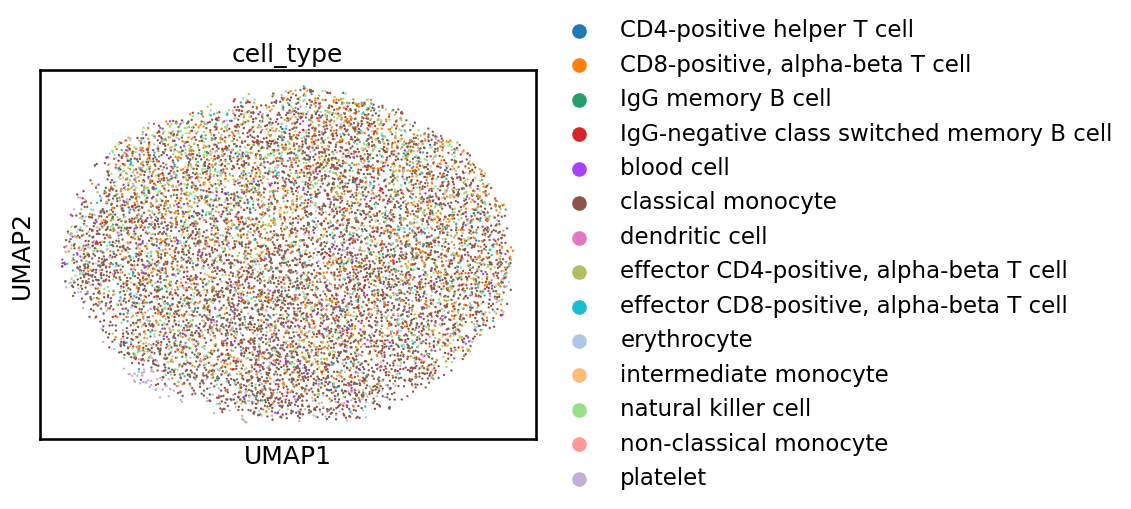

In [43]:
sc.tl.umap(flu_data_embed, min_dist=0.1, spread=10)  # Tighter UMAP
sc.pl.umap(flu_data_embed, color="cell_type")

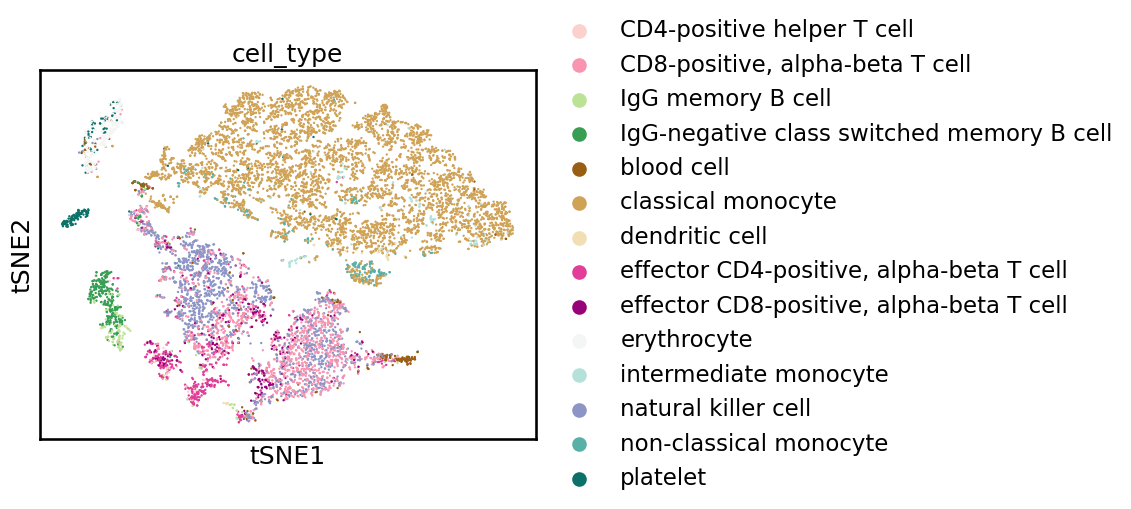

In [119]:
# TSNE Plots
sc.tl.tsne(flu_data_embed, use_rep="X_pca")
sc.pl.tsne(flu_data_embed, color="cell_type")

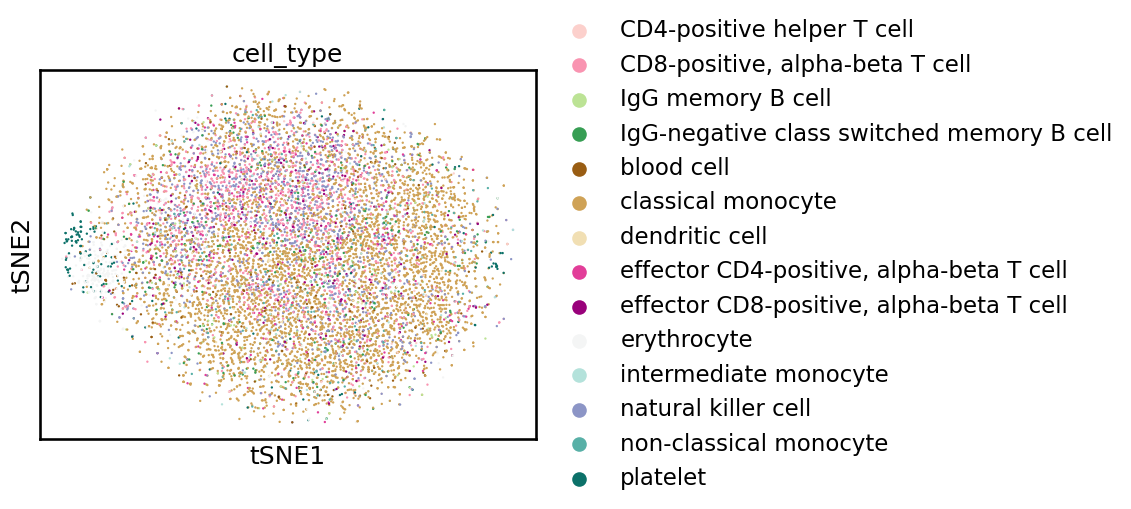

In [122]:
# TSNE Plots
sc.tl.tsne(flu_data_embed, use_rep="X_scGPT")
sc.pl.tsne(flu_data_embed, color="cell_type")

In [125]:
print(np.std(flu_data.obsm["X_scGPT"], axis=0).mean())

KeyError: 'X_scGPT'

In [121]:
sc.pp.neighbors(flu_data_embed, use_rep="X_scGPT")
sc.tl.tsne(flu_data_embed)

In [116]:
flu_data

AnnData object with n_obs × n_vars = 10519 × 61891
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'predictions', 'predicted_celltype', 'Tfh_score'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'index', 'id_in_vocab'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'predicted_celltype_colors', 'umap', 'rank_genes_groups', 'log1p', 'tsne'
    obsm: 'X_pca', 'X_umap', 'bin_edges', 'X_tsne'
    varm: 'PCs'
    laye

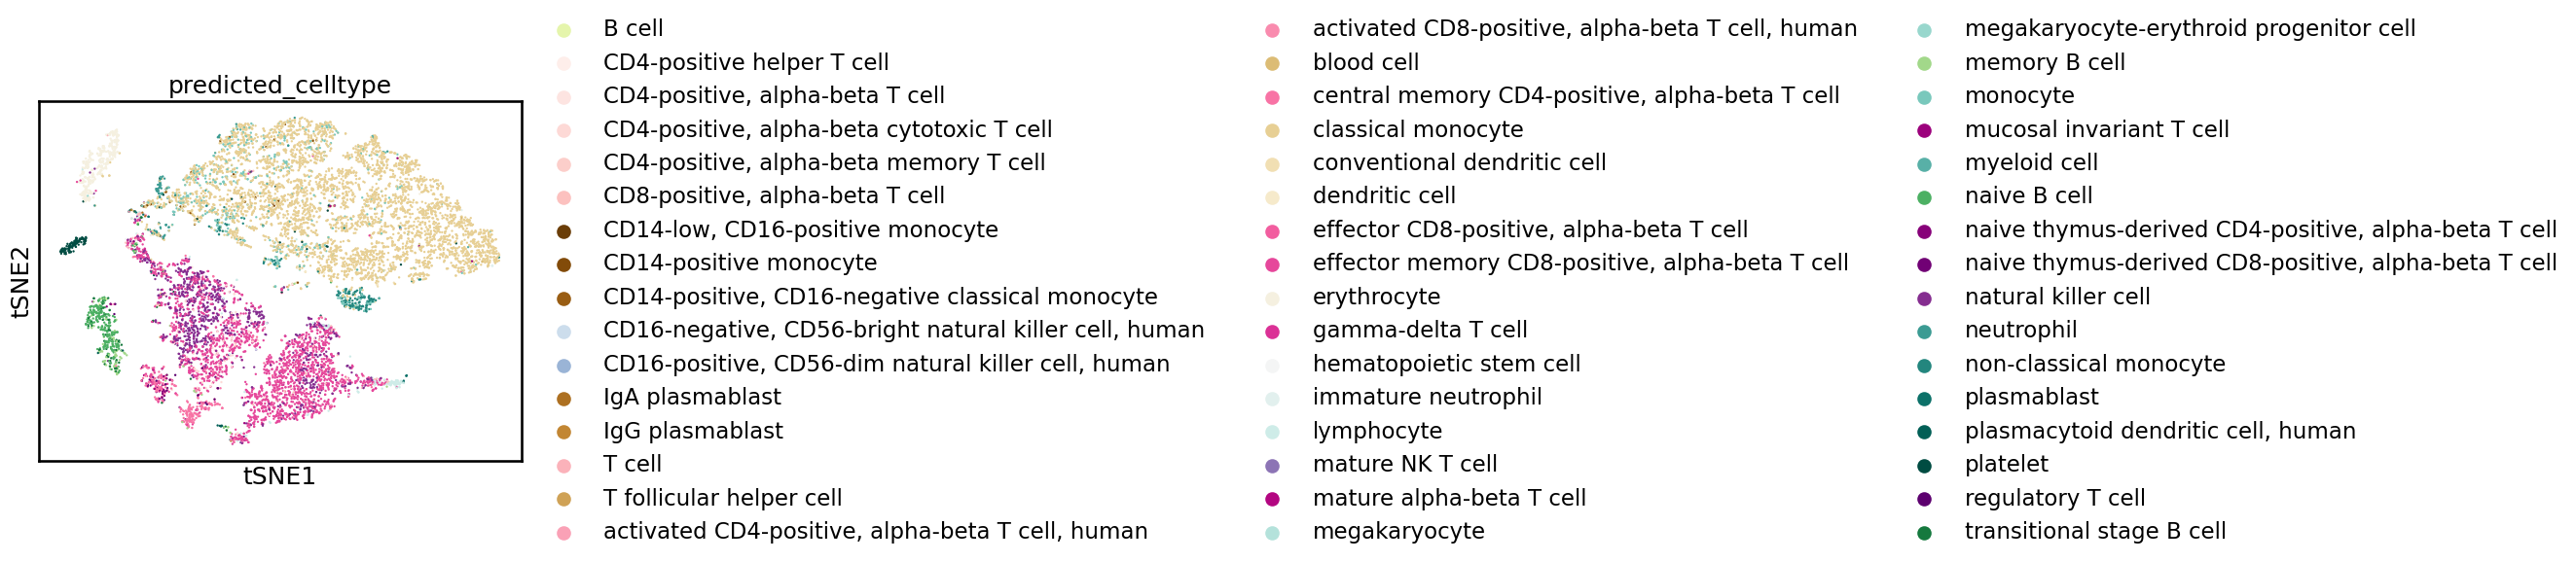

In [113]:
sc.pl.tsne(flu_data, color="predicted_celltype")

In [78]:
# Get all unique predicted cell types
cell_types = flu_data.obs["predicted_celltype"].cat.categories

print(cell_types)

monocyte_ct = [ct for ct in cell_types if "monocyte" in ct]
t_cell_ct = [ct for ct in cell_types if "T cell" in ct]
b_cell_ct = [ct for ct in cell_types if "B cell" in ct]
nk_cell_ct = [ct for ct in cell_types if "natural killer" in ct or "NK" in ct]
other_ct = [ct for ct in cell_types if ct not in t_cell_ct + b_cell_ct + nk_cell_ct]

# Generate color gradients
monocyte_palette = sns.color_palette("dark:salmon_r", len(monocyte_ct))
t_cell_palette = sns.color_palette("RdPu", len(t_cell_ct))
b_cell_palette = sns.color_palette("YlGn", len(b_cell_ct))
nk_cell_palette = sns.color_palette("BuPu", len(nk_cell_ct))
other_palette = sns.color_palette("BrBG", len(other_ct))


# Combine into a dictionary
celltype_colors = {}
for ct, color in zip(monocyte_ct, monocyte_palette):
    celltype_colors[ct] = color
for ct, color in zip(t_cell_ct, t_cell_palette):
    celltype_colors[ct] = color
for ct, color in zip(b_cell_ct, b_cell_palette):
    celltype_colors[ct] = color
for ct, color in zip(nk_cell_ct, nk_cell_palette):
    celltype_colors[ct] = color
for ct, color in zip(other_ct, other_palette):
    celltype_colors[ct] = color


Index(['B cell', 'CD4-positive helper T cell',
       'CD4-positive, alpha-beta T cell',
       'CD4-positive, alpha-beta cytotoxic T cell',
       'CD4-positive, alpha-beta memory T cell',
       'CD8-positive, alpha-beta T cell', 'CD14-low, CD16-positive monocyte',
       'CD14-positive monocyte',
       'CD14-positive, CD16-negative classical monocyte',
       'CD16-negative, CD56-bright natural killer cell, human',
       'CD16-positive, CD56-dim natural killer cell, human', 'IgA plasmablast',
       'IgG plasmablast', 'T cell', 'T follicular helper cell',
       'activated CD4-positive, alpha-beta T cell, human',
       'activated CD8-positive, alpha-beta T cell, human', 'blood cell',
       'central memory CD4-positive, alpha-beta T cell', 'classical monocyte',
       'conventional dendritic cell', 'dendritic cell',
       'effector CD8-positive, alpha-beta T cell',
       'effector memory CD8-positive, alpha-beta T cell', 'erythrocyte',
       'gamma-delta T cell', 'hematopoieti

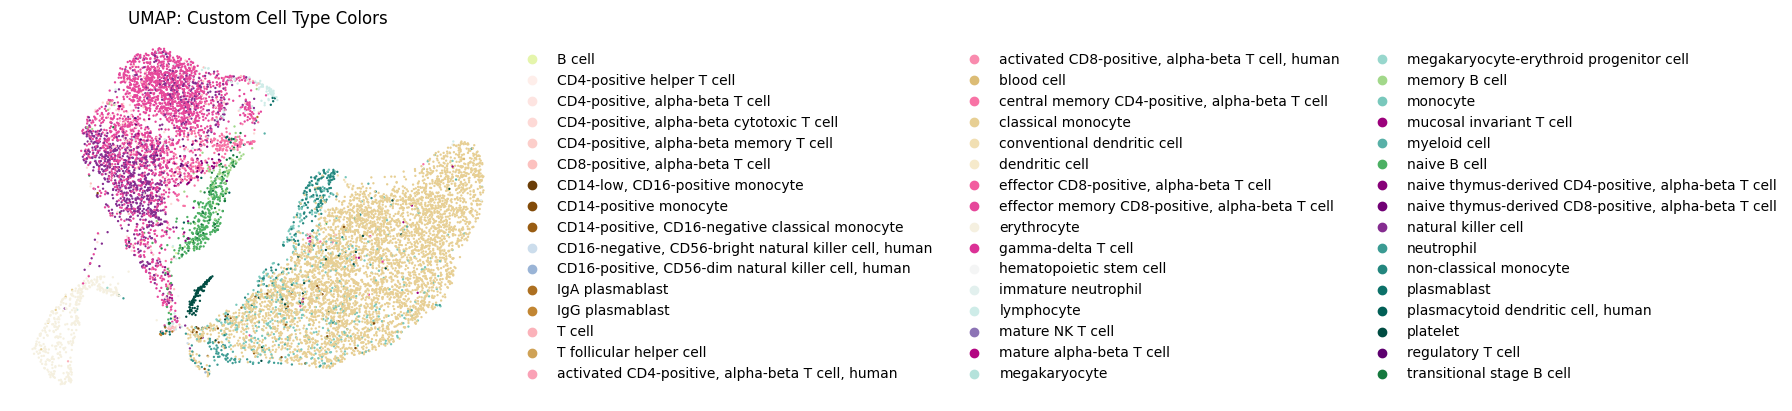

In [81]:
sc.pl.umap(
    flu_data,
    color="predicted_celltype",
    palette=celltype_colors,
    frameon=False,
    title="UMAP: Custom Cell Type Colors"
)

In [105]:
flu_data.obsm["X_scGPT"]

KeyError: 'X_scGPT'